In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from keras_hub.src.layers.modeling.rotary_embedding import RotaryEmbedding
import json
import pyarrow.parquet as pq
from functools import lru_cache
import os
import sys
from typing import Dict, Tuple, List

2025-09-22 18:26:43.352987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 18:26:43.385466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 18:26:44.048811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:2

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants for data processing
ESM_DIM = 1536  # Will be updated from metadata

# Constants
BLOSUM62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, -2, -1, 0],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, -1, 0, -1],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 3, 0, -1],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, 1, -1],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -3, -2],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2, 0, 3, -1],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -2, -1],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, 0, -1],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, -3, -3, -1],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, -4, -3, -1],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0, 1, -1],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, -3, -1, -1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, -3, -3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, -2, -1, -2],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2, 0, 0, 0],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0, -1, -1, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -3, -2],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -2, -1],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4, -3, -2, -1],
    'B': [-2, -1, 3, 4, -3, 0, 1, -1, 0, -3, -4, 0, -3, -3, -2, 0, -1, -4, -3, -3, 4, 1, -1],
    'Z': [-1, 0, 0, 1, -3, 3, 4, -2, 0, -3, -3, 1, -1, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'X': [0, -1, -1, -1, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -2, 0, 0, -2, -1, -1, -1, -1, -1],
}

# Create a reverse mapping from a BLOSUM62 vector to an amino acid character.
# The score lists are converted to tuples so they can be used as dictionary keys.
VECTOR_TO_AA = {tuple(v): k for k, v in BLOSUM62.items()}

AA = "ACDEFGHIKLMNPQRSTVWY-"
AA_TO_INT = {a: i for i, a in enumerate(AA)}
UNK_IDX = PAD_INDEX_OHE = 20  # Index for "unknown"
UNK_IDX_23 = PAD_INDEX = 22  # Index for "unknown" in BLOSUM62 (23 total chars)

MASK_TOKEN = -1.0
NORM_TOKEN = 1.0
PAD_TOKEN = -2.0
PAD_VALUE = 0.0
MASK_VALUE = 0.0

AMINO_ACID_VOCAB = "".join(list(BLOSUM62.keys()))
AMINO_ACID_MAP = {k: i for i, k in enumerate(AMINO_ACID_VOCAB)}


def seq_to_onehot(sequence: str, max_seq_len: int) -> np.ndarray:
    """Convert peptide sequence to one-hot encoding"""
    arr = np.full((max_seq_len, 21), PAD_VALUE, dtype=np.float32)  # initialize padding with 0
    for j, aa in enumerate(sequence.upper()[:max_seq_len]):
        arr[j, AA_TO_INT.get(aa, UNK_IDX)] = 1.0
        # print number of UNKs in the sequence
    # num_unks = np.sum(arr[:, UNK_IDX])
    # zero out gaps
    arr[:, AA_TO_INT['-']] = PAD_VALUE  # Set gaps to PAD_VALUE
    # if num_unks > 0:
    #     print(f"Warning: {num_unks} unknown amino acids in sequence '{sequence}'")
    return arr


def seq_to_blossom62(sequence: str, max_seq_len: int) -> np.ndarray:
    """
    Converts a peptide sequence into a matrix using BLOSUM62 substitution scores.

    This function maps each amino acid in the input sequence to its corresponding
    vector of substitution scores from the BLOSUM62 matrix. The resulting matrix
    is padded or truncated to a specified maximum length.

    Args:
        sequence (str): The input peptide sequence.
        max_seq_len (int): The target length for the output matrix. Sequences
                           shorter than this will be padded with zeros, and
                           longer ones will be truncated.

    Returns:
        np.ndarray: A NumPy array of shape (max_seq_len, 23) where each row
                    corresponds to an amino acid's BLOSUM62 scores.
    """
    # The BLOSUM62 matrix has 23 columns corresponding to the score list length.
    num_features = 23

    # Initialize the output array with the padding value (0.0).
    arr = np.full((max_seq_len, num_features), PAD_VALUE, dtype=np.float32)

    # Use the vector for 'X' (unknown) as the default for any character
    # not found in the BLOSUM62 dictionary, including gaps ('-').
    default_vector = BLOSUM62['X']

    # Iterate over the sequence up to the maximum length.
    for i, aa in enumerate(sequence.upper()[:max_seq_len]):
        # Retrieve the BLOSUM62 vector for the current amino acid.
        # If the amino acid is not a key in the dictionary, use the default vector.
        blosum_vector = BLOSUM62.get(aa, default_vector)
        arr[i, :] = blosum_vector
    return arr


def get_embed_key(key: str, emb_dict: Dict[str, str]) -> str:  # why ndarray?
    """
    Get the embedding key for a given allele key.
    If the key is not found in the embedding dictionary, return None.
    # find the matching emb key in the emb_dict.
    Sometimes the emb key is longer than the allele key, so we need to check if the key is a substring of the emb key.
    """
    # Use a generator expression for efficient lookup
    return next((emb_key for emb_key in emb_dict if emb_key.upper().startswith(key.upper())), None)


def get_seq(key: str, seq_dict: Dict[str, str]) -> str:
    """
    Get the sequence for a given allele key.
    If the key is not found in the sequence dictionary, return None.
    """
    return next((seq for seq_key, seq in seq_dict.items() if seq_key.upper().startswith(key.upper())), None)


def clean_key(allele_key: str) -> str:
    """
    Clean allele keys by removing special characters and converting to uppercase.
    This is useful for matching keys in embedding dictionaries.
    """
    if allele_key is None:
        return "None"
    mapping = str.maketrans({'*': '', ':': '', ' ': '', '/': '_'})
    return allele_key.translate(mapping).upper()


def get_mhc_seq_class2(key, embed_map, seq_map):
    # print(f"Processing key: {key}")  # Debugging line
    if key is None: return ''
    key_parts = key.split('_')
    # print(f"Key parts: {key_parts}")  # Debugging line
    if len(key_parts) >= 2:
        key1 = get_embed_key(key_parts[0], embed_map)
        key2 = get_embed_key(key_parts[1], embed_map)
        if embed_map.get(key1, None) is None or embed_map.get(key2, None) is None:
            print(
                f"Warning: Embedding not found for embd_key 1: '{key1}' 2: '{key2}' in input:'{key_parts[0]}', '{key_parts[1]}'")
        # print(f"Key1: {key1}, Key2: {key2}")  # Debugging line
        seq1 = get_seq(key_parts[0], seq_map) if key1 else ''
        seq2 = get_seq(key_parts[1], seq_map) if key2 else ''
        # print(f"Seq1: {seq1}, Seq2: {seq2}")  # Debugging line
        return seq1 + seq2
    else:
        raise ValueError(f"Unexpected MHC class II key format: '{key}'")


def get_embed_key_class2(key, embed_map):
    if key is None: return None
    key_parts = key.split('_')
    if len(key_parts) >= 2:
        key1 = get_embed_key(key_parts[0], embed_map)
        key2 = get_embed_key(key_parts[1], embed_map)
        if embed_map.get(key1, None) is None or embed_map.get(key2, None) is None:
            print(
                f"Warning: Embedding not found for embd_key 1: '{key1}' 2: '{key2}' in input:'{key_parts[0]}', '{key_parts[1]}'")
        return "_".join(filter(None, [key1, key2]))
    else:
        raise ValueError(f"Unexpected MHC class II key format: '{key}'")


@tf.function
def _neg_inf(dtype: tf.dtypes.DType) -> tf.Tensor:
    """Return a large negative constant suited for masking in given dtype."""
    if dtype == tf.float16 or dtype == tf.bfloat16:
        return tf.constant(-1e4, dtype=dtype)
    return tf.constant(-1e9, dtype=dtype)


# Custom layers from your original code
@tf.keras.utils.register_keras_serializable(package='Custom', name='AsymmetricPenaltyBinaryCrossentropy')
class AsymmetricPenaltyBinaryCrossentropy(tf.keras.losses.Loss):
    """Asymmetric Penalty Binary Cross-Entropy Loss"""

    def __init__(self, label_smoothing=0.1, asymmetry_strength=0.5,
                 name='asymmetric_penalty_binary_crossentropy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.label_smoothing = label_smoothing
        self.asymmetry_strength = asymmetry_strength

    @tf.function(reduce_retracing=True)
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        y_smooth = y_true * (1 - self.label_smoothing) + (1 - y_true) * self.label_smoothing
        base_loss = -tf.reduce_mean(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

        optimal_true1 = 1 - self.label_smoothing
        optimal_true0 = self.label_smoothing

        dist_from_optimal_true1 = tf.abs(y_pred - optimal_true1)
        dist_from_optimal_true0 = tf.abs(y_pred - optimal_true0)

        penalty_true1 = y_true * tf.where(
            y_pred < optimal_true1,
            self.asymmetry_strength * dist_from_optimal_true1 ** 2,
            self.asymmetry_strength * 0.3 * dist_from_optimal_true1 ** 2
        )

        penalty_true0 = (1 - y_true) * tf.where(
            y_pred > optimal_true0,
            self.asymmetry_strength * dist_from_optimal_true0 ** 2,
            self.asymmetry_strength * 0.3 * dist_from_optimal_true0 ** 2
        )

        total_loss = base_loss + tf.reduce_mean(penalty_true1 + penalty_true0)
        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            'label_smoothing': self.label_smoothing,
            'asymmetry_strength': self.asymmetry_strength
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='SelfAttentionWith2DMask')
class SelfAttentionWith2DMask(keras.layers.Layer):
    """Custom self-attention layer that supports 2D masks."""

    def __init__(self, query_dim, context_dim, output_dim, heads=4,
                 return_att_weights=False, name='SelfAttentionWith2DMask',
                 epsilon=1e-6, mask_token=-1., pad_token=-2., self_attn_mhc=True, apply_rope=True):
        super().__init__(name=name)
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.heads = heads
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads
        self.self_attn_mhc = self_attn_mhc
        self.apply_rope = apply_rope

    def build(self, input_shape):
        in_dim = int(input_shape[-1])
        if in_dim != self.query_dim or in_dim != self.context_dim:
            raise ValueError(
                f"Input dim {in_dim} must match query_dim {self.query_dim} and context_dim {self.context_dim}.")

        self.norm1 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln1_{self.name}')
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        self.g_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_uniform', trainable=True, name=f'g_proj_{self.name}')
        self.norm2 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln2_{self.name}')

        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.keras.mixed_precision.global_policy().compute_dtype))

        if self.apply_rope:
            if (self.att_dim % 2) != 0:
                raise ValueError(f"RotaryEmbedding requires even att_dim, got {self.att_dim}.")
            # Using keras_hub RotaryEmbedding
            self.rope = RotaryEmbedding(name=f'rope_{self.name}')

        super().build(input_shape)

    @tf.function(reduce_retracing=True)
    def call(self, x_pmhc, p_mask, m_mask):
        x_pmhc = self.norm1(x_pmhc)
        p_mask = tf.cast(p_mask, self.compute_dtype)
        m_mask = tf.cast(m_mask, self.compute_dtype)
        p_mask = tf.where(p_mask == self.pad_token, x=0., y=1.)
        m_mask = tf.where(m_mask == self.pad_token, x=0., y=1.)

        q = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.q_proj, self.compute_dtype))
        k = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.k_proj, self.compute_dtype))
        v = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.v_proj, self.compute_dtype))
        g = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.g_proj, self.compute_dtype))

        if self.apply_rope:
            q = self.rope(q)
            k = self.rope(k)

        att = tf.einsum('bhxe,bhye->bhxy', q, k) * tf.cast(self.scale, self.compute_dtype)
        mask_2d = self.mask_2d(p_mask, m_mask)
        mask_2d = tf.cast(mask_2d, self.compute_dtype)
        mask_2d_neg = (1.0 - mask_2d) * _neg_inf(att.dtype)
        att = tf.nn.softmax(att + tf.expand_dims(mask_2d_neg, axis=1), axis=-1)
        att *= tf.expand_dims(mask_2d, axis=1)
        out = tf.matmul(att, v)
        out *= tf.nn.sigmoid(g)
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x_pmhc)[0], tf.shape(x_pmhc)[1], self.heads * self.att_dim])
        out = tf.matmul(out, tf.cast(self.out_w, self.compute_dtype)) + tf.cast(self.out_b, self.compute_dtype)
        out = self.norm2(out)

        if self.return_att_weights:
            return out, att
        else:
            return out

    def mask_2d(self, p_mask, m_mask):
        p_mask = tf.cast(p_mask, self.compute_dtype)
        m_mask = tf.cast(m_mask, self.compute_dtype)
        p_mask = tf.expand_dims(p_mask, axis=-1)
        m_mask = tf.expand_dims(m_mask, axis=-1)

        # Allow peptide self-attention (small amount) to help with local context
        self_peptide_mask = 0.1 * p_mask  # Small self-attention for peptide
        self_peptide_mask_2d = tf.broadcast_to(self_peptide_mask, (
            tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(p_mask)[1]))

        # Allow MHC self-attention based on parameter
        if self.self_attn_mhc:
            self_mhc_mask = m_mask
        else:
            self_mhc_mask = 0.1 * m_mask  # Small self-attention for MHC too
        self_mhc_mask_2d = tf.broadcast_to(self_mhc_mask, (
            tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(m_mask)[1]))

        # Strong cross-attention between peptide and MHC (this is what we want!)
        pep_mhc_mask_secondpart = tf.broadcast_to(p_mask, (tf.shape(p_mask)[0], tf.shape(p_mask)[1],
                                                           tf.shape(m_mask)[-1]))
        pep_mhc_mask_secondpart = pep_mhc_mask_secondpart * tf.transpose(m_mask, perm=[0, 2, 1])

        mhc_pep_mask_secondpart = tf.broadcast_to(m_mask, (tf.shape(m_mask)[0], tf.shape(m_mask)[1],
                                                           tf.shape(p_mask)[-1]))
        mhc_pep_mask_secondpart = mhc_pep_mask_secondpart * tf.transpose(p_mask, perm=[0, 2, 1])

        combined_mask_1 = tf.concat([self_peptide_mask_2d, pep_mhc_mask_secondpart], axis=2)
        combined_mask_2 = tf.concat([mhc_pep_mask_secondpart, self_mhc_mask_2d], axis=2)
        final_mask = tf.concat([combined_mask_1, combined_mask_2], axis=1)
        final_mask_t = tf.transpose(final_mask, perm=[0, 2, 1])
        final_mask = tf.multiply(final_mask, final_mask_t)
        return final_mask


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='AddGaussianNoise')
class AddGaussianNoise(layers.Layer):
    def __init__(self, std=0.1, **kw):
        super().__init__(**kw)
        self.std = std

    @tf.function(reduce_retracing=True)
    def call(self, x, training=None):
        if training:
            noise = tf.random.normal(tf.shape(x), stddev=tf.cast(self.std, x.dtype), dtype=x.dtype)
            return x + noise
        return x


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='PositionalEncoding')
class PositionalEncoding(keras.layers.Layer):
    """Sinusoidal Positional Encoding layer that applies encodings only to non-masked tokens."""

    def __init__(self, embed_dim, pos_range=100, mask_token=-1., pad_token=-2., name='positional_encoding'):
        super().__init__(name=name)
        self.embed_dim = embed_dim
        self.pos_range = pos_range
        self.mask_token = mask_token
        self.pad_token = pad_token

    def build(self, x):
        pos = tf.range(self.pos_range, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = tf.pow(300.0, -(2.0 * tf.floor(i // 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = pos * angle_rates

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        self.pos_encoding = tf.cast(pos_encoding, dtype=self.compute_dtype)

    @tf.function(reduce_retracing=True)
    def call(self, x, mask):
        seq_len = tf.shape(x)[1]
        pe = self.pos_encoding[:, :seq_len, :]
        mask = tf.cast(mask[:, :, tf.newaxis], x.dtype)
        mask = tf.where(mask == self.pad_token, tf.cast(0.0, x.dtype), tf.cast(1.0, x.dtype))
        pe = tf.cast(pe, x.dtype) * mask
        return x + pe


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalMeanPooling1D')
class GlobalMeanPooling1D(layers.Layer):
    """Global mean pooling layer."""

    def __init__(self, axis=-1, name="global_mean_pooling_"):
        super(GlobalMeanPooling1D, self).__init__(name=name)
        self.axis = axis

    @tf.function(reduce_retracing=True)
    def call(self, input_tensor):
        return tf.math.reduce_mean(input_tensor, axis=self.axis, keepdims=False)


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalSTDPooling1D')
class GlobalSTDPooling1D(layers.Layer):
    """Global Standard Deviation Pooling layer."""

    def __init__(self, axis=1, name='global_std_pooling'):
        super(GlobalSTDPooling1D, self).__init__(name=name)
        self.axis = axis

    @tf.function(reduce_retracing=True)
    def call(self, input_tensor):
        pooled_std = tf.math.reduce_std(input_tensor, axis=self.axis, keepdims=False, name=None)
        return pooled_std + 1e-9


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalMaxPooling1D')
class GlobalMaxPooling1D(layers.Layer):
    """Global max pooling layer."""

    def __init__(self, axis=-1, name="global_max_pooling_"):
        super(GlobalMaxPooling1D, self).__init__(name=name)
        self.axis = axis

    @tf.function(reduce_retracing=True)
    def call(self, input_tensor):
        return tf.math.reduce_max(input_tensor, axis=self.axis, keepdims=False)


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='MaskedEmbedding')
class MaskedEmbedding(keras.layers.Layer):
    def __init__(self, mask_token=-1., pad_token=-2., name='masked_embedding'):
        super().__init__(name=name)
        self.mask_token = mask_token
        self.pad_token = pad_token

    @tf.function(reduce_retracing=True)
    def call(self, x, mask):
        mask = tf.cast(mask, tf.float32)
        mask = tf.where((mask == self.pad_token) | (mask == self.mask_token), 0., 1.)
        mask = tf.cast(mask, x.dtype)
        return x * mask[:, :, tf.newaxis]

    def get_config(self):
        config = super().get_config()
        config.update({
            'mask_token': self.mask_token,
            'pad_token': self.pad_token,
        })
        return config

    def __init__(self, mask_token=-1., pad_token=-2., name='masked_embedding'):
        super().__init__(name=name)
        self.mask_token = mask_token
        self.pad_token = pad_token

    @tf.function(reduce_retracing=True)
    def call(self, x, mask):
        mask = tf.cast(mask, tf.float32)
        mask = tf.where((mask == self.pad_token) | (mask == self.mask_token), 0., 1.)
        mask = tf.cast(mask, x.dtype)
        return x * mask[:, :, tf.newaxis]

    def get_config(self):
        config = super().get_config()
        config.update({
            'mask_token': self.mask_token,
            'pad_token': self.pad_token,
        })
        return config


@tf.function(reduce_retracing=True)
def masked_categorical_crossentropy(y_true_and_pred, mask, pad_token=-2.0, sample_weight=None, type='cce'):
    """Compute masked categorical cross-entropy loss."""
    y_true, y_pred = tf.split(y_true_and_pred, num_or_size_splits=2, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)

    mask = tf.cast(tf.not_equal(mask, pad_token), tf.float32)
    if mask.shape.rank is not None and mask.shape.rank > 2 and mask.shape[-1] == 1:
        mask = tf.squeeze(mask, axis=-1)

    if type == 'cce':
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    elif type == 'mse':
        loss = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    else:
        raise ValueError(f"Unsupported loss type: {type}")

    mask = tf.cast(tf.broadcast_to(mask, tf.shape(loss)), tf.float32)
    masked_loss = loss * mask

    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, tf.float32)
        if sample_weight.shape.rank == 2 and sample_weight.shape[1] == 1:
            sample_weight = tf.squeeze(sample_weight, axis=-1)
        masked_loss *= sample_weight[:, tf.newaxis]
        mask *= sample_weight[:, tf.newaxis]

    total_loss = tf.reduce_sum(masked_loss)
    total_weight = tf.reduce_sum(mask)
    ce_loss = tf.math.divide_no_nan(total_loss, total_weight)
    return tf.cast(ce_loss, tf.float32)


def pmbind_multitask_modified(max_pep_len: int,
                              max_mhc_len: int,
                              emb_dim: int = 64,
                              heads: int = 4,
                              transformer_layers: int = 2,
                              mask_token: float = MASK_TOKEN,
                              pad_token: float = PAD_TOKEN,
                              noise_std: float = 0.1,
                              latent_dim: int = 128,
                              drop_out_rate: float = 0.2,
                              l2_reg: float = 0.01,
                              ESM_dim: int = 1536):
    """
    A multi-task model for semi-supervised pMHC analysis, updated to use
    the custom SelfAttentionWith2DMask layer.
    """
    # -------------------------------------------------------------------
    # INPUTS
    # -------------------------------------------------------------------
    pep_blossom62_in = layers.Input((max_pep_len, 23), name="pep_blossom62")
    pep_mask_in = layers.Input((max_pep_len,), name="pep_mask")
    pep_ohe_target_in = layers.Input((max_pep_len, 21), name="pep_ohe_target")

    mhc_emb_in = layers.Input((max_mhc_len, ESM_dim), name="mhc_emb")
    mhc_mask_in = layers.Input((max_mhc_len,), name="mhc_mask")
    mhc_ohe_target_in = layers.Input((max_mhc_len, 21), name="mhc_ohe_target")

    # -------------------------------------------------------------------
    # SHARED ENCODER
    # -------------------------------------------------------------------
    # 1. Embed Peptide and MHC to the same dimension
    pep = MaskedEmbedding(mask_token, pad_token, name="pep_mask_embed")(pep_blossom62_in, pep_mask_in)
    pep = PositionalEncoding(23, int(max_pep_len * 3), name="pep_pos_enc")(pep, pep_mask_in)
    pep = layers.Dense(emb_dim, name="pep_dense_embed", kernel_regularizer=keras.regularizers.l2(l2_reg))(pep)
    pep = layers.SpatialDropout1D(drop_out_rate, name="pep_dropout")(
        pep)  # SpatialDropout1D for sequence data to drop entire feature maps

    mhc = MaskedEmbedding(mask_token, pad_token, name="mhc_mask_embed")(mhc_emb_in, mhc_mask_in)
    mhc = PositionalEncoding(ESM_dim, int(max_mhc_len * 3), name="mhc_pos_enc")(mhc, mhc_mask_in)
    mhc = layers.Dense(emb_dim, name="mhc_dense_embed", kernel_regularizer=keras.regularizers.l2(l2_reg))(mhc)
    mhc = layers.SpatialDropout1D(drop_out_rate, name="mhc_dropout")(
        mhc)  # SpatialDropout1D for sequence data to drop entire feature maps
    mhc = layers.LayerNormalization(name="mhc_layer_norm")(mhc)

    # add Gaussian noise
    pep = AddGaussianNoise(noise_std, name="pep_gaussian_noise")(pep)
    mhc = AddGaussianNoise(noise_std, name="mhc_gaussian_noise")(mhc)

    pmhc_concat = layers.Concatenate(axis=1, name="pmhc_concat")([pep, mhc])  # (B, P+M, D)

    # pmhc self-attention with 2D mask
    pmhc_interaction, pmhc_attn_weights = SelfAttentionWith2DMask(
        query_dim=emb_dim,
        context_dim=emb_dim,
        output_dim=emb_dim,
        heads=heads,
        return_att_weights=True,
        self_attn_mhc=False,  # Prevent both peptide and MHC self-attention in this layer
        apply_rope=True,
        name="pmhc_2d_masked_attention"
    )(pmhc_concat, pep_mask_in, mhc_mask_in)

    # The final output of the encoder is our shared latent sequence
    latent_sequence = pmhc_interaction  # Shape: (B, P+M, D)
    latent_sequence = layers.BatchNormalization(name="latent_sequence_norm")(latent_sequence)

    # -------------------------------------------------------------------
    # TASK 1: BINDING PREDICTION HEAD # TODO this part directly affects clustering
    # -------------------------------------------------------------------
    # pooled_mean2 = GlobalMeanPooling1D(name="latent_vector_pool-2", axis=-2)(latent_sequence) # (B, D) # Tells how strong the overall signal is across the sequence (using this forces the model to pu one feature as the distance/binder information)
    pooled_std2 = GlobalSTDPooling1D(name="latent_vector_std-2", axis=-2)(
        latent_sequence)  # (B, D) # Tells how much variation there is in the signal across the sequence
    pooled_mean1 = GlobalMeanPooling1D(name="latent_vector_pool-1", axis=-1)(
        latent_sequence)  # (B, P+M) # Tells how strong the overall signal is across the features
    # pooled_std1 = GlobalSTDPooling1D(name="latent_vector_std-1", axis=-1)(latent_sequence)  # (B, P+M) # Tells how much variation there is in the signal across the features

    # concatenate mean and std pooled vectors
    pooled_latent = layers.Concatenate(name="pooled_latent_concat", axis=-1)(
        [pooled_mean1, pooled_std2])  # (B, 1*(D+P+M))

    binding_head = layers.Dense(emb_dim, activation="gelu", name="binding_dense1",
                                kernel_regularizer=keras.regularizers.l2(l2_reg))(pooled_latent)
    binding_head = layers.GaussianDropout((drop_out_rate * 2), name="binding_gaussian_dropout")(binding_head)
    binding_pred = layers.Dense(1, activation="sigmoid", name="binding_pred", dtype="float32")(binding_head)  # (B, 1)

    # -------------------------------------------------------------------
    # TASK 2: RECONSTRUCTION HEAD
    # -------------------------------------------------------------------
    pep_latent_seq = latent_sequence[:, :max_pep_len, :]  # (B, P, D)
    mhc_latent_seq = latent_sequence[:, max_pep_len:, :]  # (B, M, D)

    pep_recon_head = layers.Dense(emb_dim * 2, activation='relu')(pep_latent_seq)
    pep_recon_head = layers.Dropout(drop_out_rate, name='pep_recon_dropout')(pep_recon_head)
    pep_recon_pred = layers.Dense(21, activation='softmax', name='pep_reconstruction_pred')(pep_recon_head)

    mhc_recon_head = layers.Dense(emb_dim * 2, activation='relu')(mhc_latent_seq)
    mhc_recon_head = layers.Dropout(drop_out_rate, name='mhc_recon_dropout')(mhc_recon_head)
    mhc_recon_pred = layers.Dense(21, activation='softmax', name='mhc_reconstruction_pred')(mhc_recon_head)

    pep_out = layers.Concatenate(name='pep_ytrue_ypred')([pep_ohe_target_in, pep_recon_pred])
    mhc_out = layers.Concatenate(name='mhc_ytrue_ypred')([mhc_ohe_target_in, mhc_recon_pred])

    # -------------------------------------------------------------------
    # MODEL DEFINITION
    # -------------------------------------------------------------------
    pMHC_multitask_model = keras.Model(
        inputs=[pep_blossom62_in, pep_mask_in, mhc_emb_in, mhc_mask_in, pep_ohe_target_in, mhc_ohe_target_in],
        outputs={
            "pep_ytrue_ypred": pep_out,
            "mhc_ytrue_ypred": mhc_out,
            "cls_ypred": binding_pred,
            "attn_weights": pmhc_attn_weights,  # (B, heads, P+M, P+M)
            "latent_vector": pooled_latent,  # (B, P+M+D)
            "latent_seq": latent_sequence  # (B, P+M, D)
        },
        name="pMHC_Multitask_Transformer_Custom_Attention"
    )

    return pMHC_multitask_model


In [3]:
# ============================================================================
# PARQUET DATA LOADING WITH DATAGENERATOR AND DYNAMIC MASKING
# ============================================================================

# Global variables for DataGenerator
EMB_DB: np.lib.npyio.NpzFile | None = None
MHC_CLASS = 1


def load_embedding_db(npz_path: str):
    """Load embedding database with memory mapping."""
    try:
        # Try loading without explicit allow_pickle (defaults to True)
        return np.load(npz_path, mmap_mode="r")
    except ValueError as e:
        if "allow_pickle" in str(e):
            # If pickle error, try with explicit allow_pickle=True
            print(f"Warning: NPZ file contains pickled data, loading with allow_pickle=True")
            return np.load(npz_path, mmap_mode="r", allow_pickle=True)
        else:
            raise e


def apply_dynamic_masking(features, emd_mask_d2=True):
    """
    Applies random masking for training augmentation inside the tf.data pipeline.
    This version is corrected to match the original DataGenerator logic.
    """
    # Peptide Masking
    valid_pep_positions = tf.where(tf.equal(features["pep_mask"], NORM_TOKEN))
    num_valid_pep = tf.shape(valid_pep_positions)[0]
    # At least 2 positions, or 15% of the valid sequence length
    num_to_mask_pep = tf.maximum(2, tf.cast(tf.cast(num_valid_pep, tf.float32) * 0.15, tf.int32))
    shuffled_pep_indices = tf.random.shuffle(valid_pep_positions)[:num_to_mask_pep]
    if tf.shape(shuffled_pep_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["pep_mask"] = tf.tensor_scatter_nd_update(features["pep_mask"], shuffled_pep_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_pep))
        # Zero out the feature values for the masked positions
        feat_dtype = features["pep_blossom62"].dtype
        mask_updates_pep = tf.fill([num_to_mask_pep, tf.shape(features["pep_blossom62"])[-1]],
                                   tf.cast(MASK_VALUE, feat_dtype))
        features["pep_blossom62"] = tf.tensor_scatter_nd_update(features["pep_blossom62"], shuffled_pep_indices,
                                                                mask_updates_pep)
    # MHC Masking
    valid_mhc_positions = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
    num_valid_mhc = tf.shape(valid_mhc_positions)[0]
    # At least 5 positions, or 15% of the valid sequence length
    num_to_mask_mhc = tf.maximum(10, tf.cast(tf.cast(num_valid_mhc, tf.float32) * 0.15, tf.int32))
    shuffled_mhc_indices = tf.random.shuffle(valid_mhc_positions)[:num_to_mask_mhc]
    if tf.shape(shuffled_mhc_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["mhc_mask"] = tf.tensor_scatter_nd_update(features["mhc_mask"], shuffled_mhc_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_mhc))
        # Zero out the feature values for the masked positions
        mhc_dtype = features["mhc_emb"].dtype
        mask_updates_mhc = tf.fill([num_to_mask_mhc, tf.shape(features["mhc_emb"])[-1]], tf.cast(MASK_VALUE, mhc_dtype))
        features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], shuffled_mhc_indices, mask_updates_mhc)

    # Dimension-level masking for MHC embeddings
    if emd_mask_d2:
        # Find positions that are STILL valid (not padded and not positionally masked)
        remaining_valid_mhc = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
        if tf.shape(remaining_valid_mhc)[0] > 0:
            # Get the embeddings at these remaining valid positions
            valid_embeddings = tf.gather_nd(features["mhc_emb"], remaining_valid_mhc)
            # Create a random mask for the feature dimensions
            dim_mask = tf.random.uniform(shape=tf.shape(valid_embeddings), dtype=features["mhc_emb"].dtype) < tf.cast(
                0.15, features["mhc_emb"].dtype)
            # Apply the mask (multiply by 0 where True, 1 where False)
            masked_embeddings = valid_embeddings * tf.cast(~dim_mask, features["mhc_emb"].dtype)
            # Scatter the modified embeddings back into the original tensor
            features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], remaining_valid_mhc,
                                                              masked_embeddings)
    return features


class OptimizedDataGenerator(keras.utils.Sequence):
    """Optimized data generator for training with dynamic masking support."""

    def __init__(self, df, seq_map, embed_map, max_pep_len, max_mhc_len, batch_size, apply_masking=True):
        super().__init__()
        self.df = df
        self.seq_map = seq_map
        self.embed_map = embed_map
        self.max_pep_len = max_pep_len
        self.max_mhc_len = max_mhc_len
        self.batch_size = batch_size
        self.apply_masking = apply_masking
        self.long_mer_arr = df['long_mer'].to_numpy()
        self.emb_key_arr = df['_emb_key'].to_numpy()
        self.cleaned_key_arr = df['_cleaned_key'].to_numpy()
        self.mhc_seq_arr = df['_mhc_seq'].to_numpy()
        self.label_arr = df['assigned_label'].to_numpy()
        self.indices = np.arange(len(df))

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        start_idx, end_idx = index * self.batch_size, min((index + 1) * self.batch_size, len(self.indices))
        return self._generate_batch(self.indices[start_idx:end_idx])

    def _get_embedding(self, emb_key, cleaned_key):
        if MHC_CLASS == 2:
            parts = cleaned_key.split('_')
            if len(parts) >= 2:
                k1, k2 = get_embed_key(clean_key(parts[0]), self.embed_map), get_embed_key(clean_key(parts[1]),
                                                                                           self.embed_map)
                return np.concatenate([EMB_DB[k1], EMB_DB[k2]], axis=0)
        return EMB_DB[emb_key]

    def _generate_batch(self, batch_indices):
        n = len(batch_indices)
        data = {"pep_blossom62": np.zeros((n, self.max_pep_len, 23), np.float32),
                "pep_mask": np.full((n, self.max_pep_len), PAD_TOKEN, dtype=np.float32),
                "mhc_emb": np.zeros((n, self.max_mhc_len, ESM_DIM), np.float32),
                "mhc_mask": np.full((n, self.max_mhc_len), PAD_TOKEN, dtype=np.float32),
                "pep_ohe_target": np.zeros((n, self.max_pep_len, 21), np.float32),
                "mhc_ohe_target": np.zeros((n, self.max_mhc_len, 21), np.float32),
                "labels": np.zeros((n, 1), np.float32)}

        for i, master_idx in enumerate(batch_indices):
            pep_seq, emb_key, cleaned_key, mhc_seq = (self.long_mer_arr[master_idx].upper(),
                                                      self.emb_key_arr[master_idx],
                                                      self.cleaned_key_arr[master_idx],
                                                      self.mhc_seq_arr[master_idx])
            pep_len = len(pep_seq)
            data["pep_blossom62"][i] = seq_to_blossom62(pep_seq, max_seq_len=self.max_pep_len)
            data["pep_ohe_target"][i] = seq_to_onehot(pep_seq, max_seq_len=self.max_pep_len)
            data["pep_mask"][i, :pep_len] = NORM_TOKEN
            emb = self._get_embedding(emb_key, cleaned_key)
            L = emb.shape[0]
            data["mhc_emb"][i, :L] = emb
            data["mhc_emb"][i, L:, :] = PAD_VALUE
            data["mhc_mask"][i, ~np.all(data["mhc_emb"][i] == PAD_VALUE, axis=-1)] = NORM_TOKEN
            data["mhc_ohe_target"][i] = seq_to_onehot(mhc_seq, max_seq_len=self.max_mhc_len)
            data["labels"][i, 0] = float(self.label_arr[master_idx])

        # Convert to tensors
        tensor_data = {k: tf.convert_to_tensor(v) for k, v in data.items()}

        # Apply dynamic masking if enabled
        if self.apply_masking:
            tensor_data = apply_dynamic_masking(tensor_data, emd_mask_d2=True)

        return tensor_data


from concurrent.futures import ProcessPoolExecutor


def _preprocess_df_chunk(args):
    """Top-level helper for multiprocessing chunk processing."""
    chunk, seq_map, embed_map, mhc_class = args
    chunk = chunk.copy()

    # Replicate original logic
    chunk['_cleaned_key'] = chunk.apply(
        lambda r: r.get('mhc_embedding_key', r['allele'].replace(' ', '').replace('*', '').replace(':', '')),
        axis=1
    )
    chunk['_emb_key'] = chunk['_cleaned_key'].apply(lambda k: get_embed_key(clean_key(k), embed_map))

    if mhc_class == 2:
        def _get_mhc_seq_class2(key):
            parts = key.split('_')
            return seq_map.get(get_embed_key(clean_key(parts[0]), seq_map), '') + \
                   seq_map.get(get_embed_key(clean_key(parts[1]), seq_map), '') if len(parts) >= 2 else ''

        chunk['_mhc_seq'] = chunk['_cleaned_key'].apply(_get_mhc_seq_class2)
    else:
        chunk['_mhc_seq'] = chunk['_emb_key'].apply(lambda k: seq_map.get(get_embed_key(clean_key(k), seq_map), ''))

    return chunk


def preprocess_df(df, seq_map, embed_map, workers=None, chunks=None):
    """
    Multiprocessed preprocessing. Splits df into chunks, processes in parallel, and
    preserves original order. Backward compatible with existing calls.
    """
    if workers is None:
        workers = max(1, os.cpu_count() // 2 or 1)
    if chunks is None:
        chunks = max(1, min(workers * 4, len(df)))  # more chunks than workers for load balancing

    parts = np.array_split(df, chunks)
    args = [(part, seq_map, embed_map, MHC_CLASS) for part in parts]

    if workers == 1 or len(parts) == 1:
        processed = [_preprocess_df_chunk(a) for a in args]
    else:
        with ProcessPoolExecutor(max_workers=workers) as ex:
            processed = list(ex.map(_preprocess_df_chunk, args))

    out = pd.concat(processed, axis=0)
    out = out.loc[df.index]  # preserve original row order
    return out


# Load parquet data and setup - Updated paths for local environment
parquet_dir = 'dataset/parquets'  # Local path
allele_seq_path = '../data/alleles/aligned_PMGen_class_1.csv'  # Local path
embedding_key_path = 'dataset/ESM/PMDb_ESM_embeddings_mhc1_encodings.csv'  # Local path
embedding_npz_path = 'dataset/ESM/PMDb_ESM_embeddings_mhc1.npz'  # Local path

# Configuration
config = {
    "MHC_CLASS": 1,
    "MAX_PEP_LEN": 15,
    "MAX_MHC_LEN": 365,
    "EMBED_DIM": 32,
    "HEADS": 2
}

MHC_CLASS = config["MHC_CLASS"]
pep_len = config["MAX_PEP_LEN"]
mhc_len = config["MAX_MHC_LEN"]
ESM_DIM = 1536  # ESM embedding dimension (will be updated after loading embeddings)

print(f"Dataset configuration:")
print(f"Max peptide length: {pep_len}")
print(f"Max MHC length: {mhc_len}")
print(f"ESM embedding dimension: {ESM_DIM} (preliminary)")
print(f"MHC Class: {MHC_CLASS}")

# Load embedding database
print(f"\nLoading embedding database from: {embedding_npz_path}")
if not os.path.exists(embedding_npz_path):
    print(f"Error: Embedding NPZ file not found at {embedding_npz_path}")
    raise FileNotFoundError(f"Embedding NPZ file not found: {embedding_npz_path}")

EMB_DB = load_embedding_db(embedding_npz_path)
print(f"Loaded embedding database with {len(EMB_DB.files)} embeddings")
print(f"Sample embedding keys: {list(EMB_DB.files)[:5]}")

# Check embedding dimension
first_key = EMB_DB.files[0]
first_embedding = EMB_DB[first_key]
print(f"First embedding shape: {first_embedding.shape}, dtype: {first_embedding.dtype}")
ESM_DIM = first_embedding.shape[1] if len(first_embedding.shape) > 1 else first_embedding.shape[0]
print(f"Updated ESM embedding dimension: {ESM_DIM}")

# Load sequence and embedding mappings
print("\nLoading sequence and embedding mappings...")
print(f"Allele sequence file: {allele_seq_path}")
print(f"Embedding key file: {embedding_key_path}")

# Check if files exist
if not os.path.exists(allele_seq_path):
    print(f"Error: Allele sequence file not found at {allele_seq_path}")
    raise FileNotFoundError(f"Allele sequence file not found: {allele_seq_path}")

if not os.path.exists(embedding_key_path):
    print(f"Error: Embedding key file not found at {embedding_key_path}")
    raise FileNotFoundError(f"Embedding key file not found: {embedding_key_path}")

# Load with error handling
try:
    seq_df = pd.read_csv(allele_seq_path, index_col="allele")
    seq_map = {clean_key(k): v for k, v in seq_df["mhc_sequence"].to_dict().items()}
except Exception as e:
    print(f"Error loading sequence file: {e}")
    print(f"Available columns in {allele_seq_path}:")
    temp_df = pd.read_csv(allele_seq_path)
    print(temp_df.columns.tolist())
    raise e

try:
    embed_df = pd.read_csv(embedding_key_path, index_col="key")
    embed_map = embed_df["mhc_sequence"].to_dict()
except Exception as e:
    print(f"Error loading embedding key file: {e}")
    print(f"Available columns in {embedding_key_path}:")
    temp_df = pd.read_csv(embedding_key_path)
    print(temp_df.columns.tolist())
    raise e

print(f"Loaded {len(seq_map)} sequence mappings")
print(f"Loaded {len(embed_map)} embedding key mappings")

# Load training and validation data
train_parquet_path = os.path.join(parquet_dir, 'fold_01_train_balanced.parquet')
val_parquet_path = os.path.join(parquet_dir, 'fold_01_val.parquet')

print("\nLoading parquet files...")
print(f"Training file: {train_parquet_path}")
print(f"Validation file: {val_parquet_path}")

# Check if files exist
if not os.path.exists(train_parquet_path):
    print(f"Error: Training file not found at {train_parquet_path}")
    print("Available files in parquet directory:")
    for f in os.listdir(parquet_dir):
        print(f"  {f}")
    raise FileNotFoundError(f"Training parquet file not found: {train_parquet_path}")

if not os.path.exists(val_parquet_path):
    print(f"Error: Validation file not found at {val_parquet_path}")
    raise FileNotFoundError(f"Validation parquet file not found: {val_parquet_path}")

train_df = pd.read_parquet(train_parquet_path)
val_df = pd.read_parquet(val_parquet_path)

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Training columns: {list(train_df.columns)}")

# Preprocess dataframes
print("\nPreprocessing datasets...")
train_df = preprocess_df(train_df, seq_map, embed_map)
val_df = preprocess_df(val_df, seq_map, embed_map)

Dataset configuration:
Max peptide length: 15
Max MHC length: 365
ESM embedding dimension: 1536 (preliminary)
MHC Class: 1

Loading embedding database from: dataset/ESM/PMDb_ESM_embeddings_mhc1.npz
Loaded embedding database with 423 embeddings
Sample embedding keys: ['BOLA-301001', 'BOLA-100901', 'BOLA-101901', 'BOLA-102301', 'BOLA-200801']
First embedding shape: (312, 1536), dtype: float32
Updated ESM embedding dimension: 1536

Loading sequence and embedding mappings...
Allele sequence file: ../data/alleles/aligned_PMGen_class_1.csv
Embedding key file: dataset/ESM/PMDb_ESM_embeddings_mhc1_encodings.csv
Loaded 30577 sequence mappings
Loaded 423 embedding key mappings

Loading parquet files...
Training file: dataset/parquets/fold_01_train_balanced.parquet
Validation file: dataset/parquets/fold_01_val.parquet
Training samples: 1,422,892
Validation samples: 2,839
Training columns: ['allele', 'assigned_label', 'long_mer', 'mhc_embedding_key']

Preprocessing datasets...


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Created data generators:
Training batches: 20
Validation batches: 4
Batch size: 256


I0000 00:00:1758558561.010157  316274 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7424 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6



Model Summary:


Model: "pMHC_Multitask_Transformer_Custom_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mhc_emb             │ (None, 365, 1536) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask            │ (None, 365)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_blossom62       │ (None, 15, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask            │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_mask_embed      │ (None, 365, 1536) │          0 │ mhc_emb[0][0],    │
│ (MaskedEmbedding)   │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_mask_embed      │ (None, 15, 23)    │          0 │ pep_blossom62[0]… │
│ (MaskedEmbedding)   │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_pos_enc         │ (None, 365, 1536) │          0 │ mhc_mask_embed[0… │
│ (PositionalEncodin… │                   │            │ mhc_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_pos_enc         │ (None, 15, 23)    │          0 │ pep_mask_embed[0… │
│ (PositionalEncodin… │                   │            │ pep_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_dense_embed     │ (None, 365, 32)   │     49,184 │ mhc_pos_enc[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_dense_embed     │ (None, 15, 32)    │        768 │ pep_pos_enc[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_dropout         │ (None, 365, 32)   │          0 │ mhc_dense_embed[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_dropout         │ (None, 15, 32)    │          0 │ pep_dense_embed[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_layer_norm      │ (None, 365, 32)   │         64 │ mhc_dropout[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pep_gaussian_noise  │ (None, 15, 32)    │          0 │ pep_dropout[0][0] │
│ (AddGaussianNoise)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_gaussian_noise  │ (None, 365, 32)   │          0 │ mhc_layer_norm[0… │
│ (AddGaussianNoise)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pmhc_concat         │ (None, 380, 32)   │          0 │ pep_gaussian_noi… │
│ (Concatenate)       │                   │            │ mhc_gaussian_noi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pmhc_2d_masked_att… │ [(None, 380, 32), │      5,280 │ pmhc_concat[0][0

 Total params: 75,627 (295.42 KB)

 Trainable params: 75,563 (295.17 KB)

 Non-trainable params: 64 (256.00 B)


Starting training with DataGenerator and dynamic masking...

Epoch 1/20


/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['pmhc_2d_masked_attention/ln1_pmhc_2d_masked_attention/gamma', 'pmhc_2d_masked_attention/ln1_pmhc_2d_masked_attention/beta', 'pmhc_2d_masked_attention/ln2_pmhc_2d_masked_attention/gamma', 'pmhc_2d_masked_attention/ln2_pmhc_2d_masked_attention/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 1/20 - Loss: 3.3873 - AUC: 0.5966 - Val Loss: 3.3165 - Val AUC: 0.5567

Epoch 2/20
  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 2/20 - Loss: 3.1715 - AUC: 0.6902 - Val Loss: 3.3150 - Val AUC: 0.5927

Epoch 3/20
  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 3/20 - Loss: 2.9458 - AUC: 0.7225 - Val Loss: 3.1291 - Val AUC: 0.5895

Epoch 4/20
  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 4/20 - Loss: 2.6405 - AUC: 0.7624 - Val Loss: 3.0134 - Val AUC: 0.5404

Epoch 5/20
  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 5/20 - Loss: 2.3769 - AUC: 0.8053 - Val Loss: 2.7787 - Val AUC: 0.5316

Epoch 6/20
  Processed 10/20 training batches
  Processed 20/20 training batches
Epoch 6/20 - Loss: 2.1724 - AUC: 0.8336 - Val Loss: 2.7020 - Val AUC: 0.5629

Epoch 7/20
  Processed 10/20 training batches
  Processed

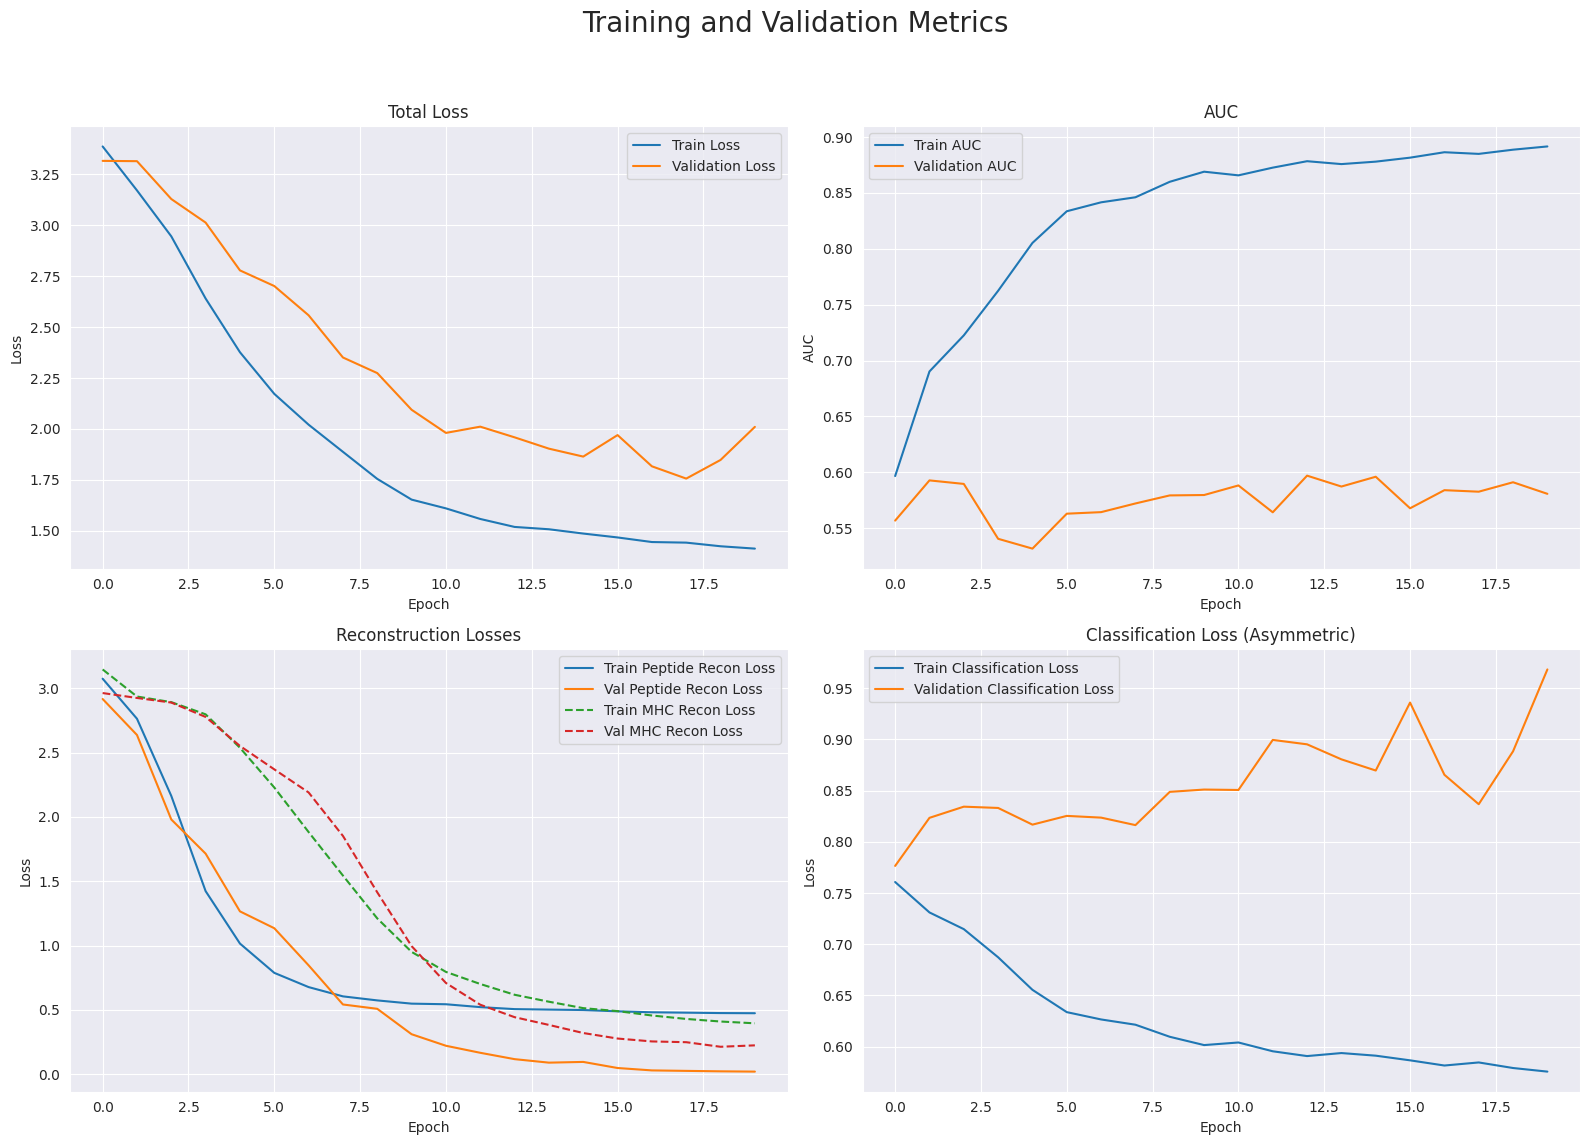


Visualizing attention weights...


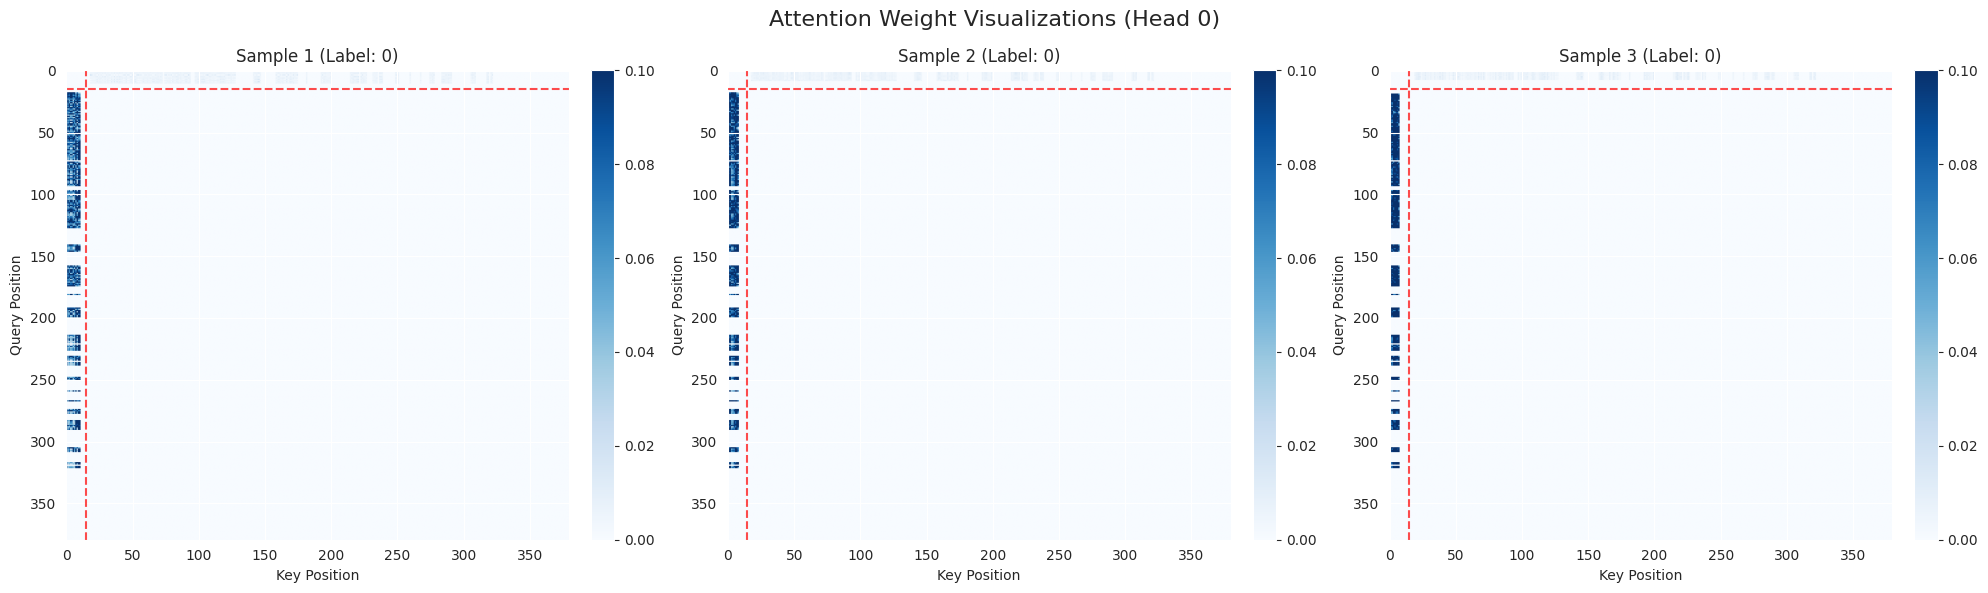


Visualizing latent space...


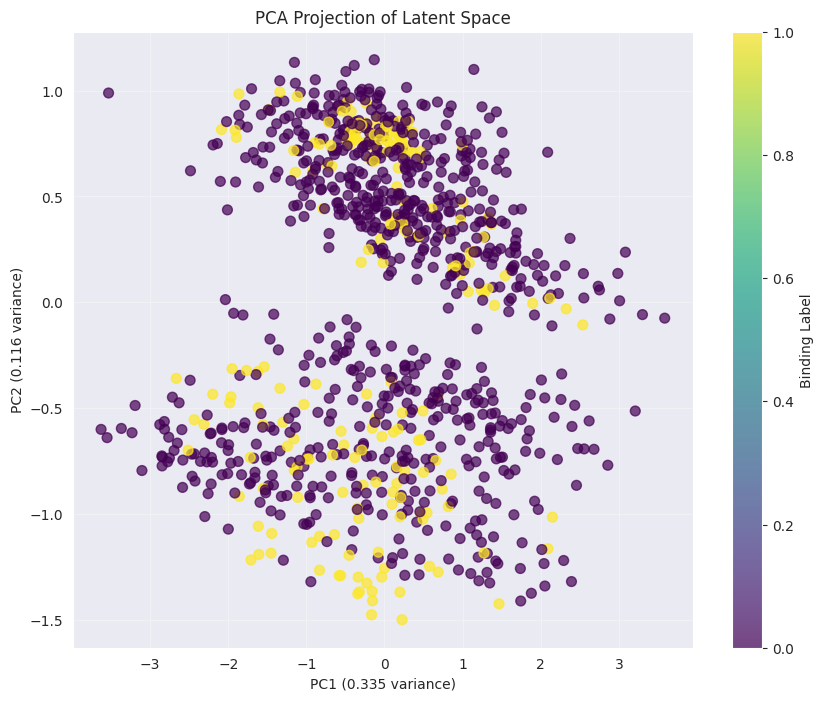

Visualization complete!

Key changes made:
1. Replaced TFRecord data loading with DataGenerator from src/infer.py
2. Added dynamic masking logic from tests/Dynamic_masking.py
3. Updated to work with parquet files instead of TFRecords
4. DataGenerator applies dynamic masking during training for data augmentation
5. Masking includes both positional masking and dimension-level masking for robustness


In [4]:

# ============================================================================
# MODEL SETUP AND TRAINING WITH DATAGENERATOR
# ============================================================================
epochs = 20  # Reduced for testing
batch_size = 256  # Adjusted for DataGenerator
learning_rate = 1e-3
emb_dim = config["EMBED_DIM"]
heads = config["HEADS"]
noise_std = 0.1

# Create data generators
train_generator = OptimizedDataGenerator(
    df=train_df.sample(n=min(5000, len(train_df))),  # Sample for demo
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=True  # Enable dynamic masking for training
)

val_generator = OptimizedDataGenerator(
    df=val_df.sample(n=min(1000, len(val_df))),  # Sample for demo
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=False  # No masking for validation
)

print(f"\nCreated data generators:")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Batch size: {batch_size}")

# Instantiate model
model = pmbind_multitask_modified(
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    emb_dim=emb_dim,
    heads=heads,
    noise_std=noise_std,
    mask_token=MASK_TOKEN,
    pad_token=PAD_TOKEN,
    ESM_dim=ESM_DIM
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)

# Use AsymmetricPenaltyBinaryCrossentropy as the binary loss function
binary_loss_fn = AsymmetricPenaltyBinaryCrossentropy(
    label_smoothing=0.1,
    asymmetry_strength=0.5
)

# Metrics for tracking
metrics_names = ['loss', 'pep_recon_loss', 'mhc_recon_loss', 'class_loss', 'auc']
train_metrics = {name: tf.keras.metrics.Mean(name=f"train_{name}") for name in metrics_names}
val_metrics = {name: tf.keras.metrics.Mean(name=f"val_{name}") for name in metrics_names}
train_metrics['auc'] = tf.keras.metrics.AUC(name='train_auc')
val_metrics['auc'] = tf.keras.metrics.AUC(name='val_auc')

print("\nModel Summary:")
model.summary()


# Training and validation steps with DataGenerator support
def train_step(batch_data):
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]

    with tf.GradientTape() as tape:
        predictions = model(x_batch_list, training=True)

        pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'],
                                                   batch_data['pep_mask'], PAD_TOKEN)
        mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'],
                                                   batch_data['mhc_mask'], PAD_TOKEN)
        class_loss = binary_loss_fn(batch_data['labels'], predictions['cls_ypred'])

        # Weighted loss - prioritize classification task
        total_loss = 0.3 * pep_loss + 0.3 * mhc_loss + 2.0 * class_loss

    grads = tape.gradient(total_loss, model.trainable_variables)

    # Gradient clipping to stabilize training
    grads = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in grads]

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_metrics['loss'](total_loss)
    train_metrics['pep_recon_loss'](pep_loss)
    train_metrics['mhc_recon_loss'](mhc_loss)
    train_metrics['class_loss'](class_loss)
    train_metrics['auc'](batch_data['labels'], predictions['cls_ypred'])


def val_step(batch_data):
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]

    predictions = model(x_batch_list, training=False)

    pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'],
                                               batch_data['pep_mask'], PAD_TOKEN)
    mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'],
                                               batch_data['mhc_mask'], PAD_TOKEN)
    class_loss = binary_loss_fn(batch_data['labels'], predictions['cls_ypred'])

    # Same weighted loss for validation
    total_loss = 0.3 * pep_loss + 0.3 * mhc_loss + 2.0 * class_loss

    val_metrics['loss'](total_loss)
    val_metrics['pep_recon_loss'](pep_loss)
    val_metrics['mhc_recon_loss'](mhc_loss)
    val_metrics['class_loss'](class_loss)
    val_metrics['auc'](batch_data['labels'], predictions['cls_ypred'])


# Training loop with DataGenerator
history = {f"{key}": [] for key in train_metrics.keys()}
history.update({f"val_{key}": [] for key in val_metrics.keys()})

print("\nStarting training with DataGenerator and dynamic masking...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    # Reset metrics
    for metric in train_metrics.values(): metric.reset_state()
    for metric in val_metrics.values(): metric.reset_state()

    # Training with DataGenerator
    train_batches = 0
    for batch_idx in range(len(train_generator)):
        batch_data = train_generator[batch_idx]
        train_step(batch_data)
        train_batches += 1
        if train_batches % 10 == 0:
            print(f"  Processed {train_batches}/{len(train_generator)} training batches")

    # Validation with DataGenerator
    val_batches = 0
    for batch_idx in range(len(val_generator)):
        batch_data = val_generator[batch_idx]
        val_step(batch_data)
        val_batches += 1

    # Log results
    train_results = {key: value.result().numpy() for key, value in train_metrics.items()}
    val_results = {key: value.result().numpy() for key, value in val_metrics.items()}

    # Store history
    for key, value in train_results.items(): history[key].append(value)
    for key, value in val_results.items(): history[f"val_{key}"].append(value)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Loss: {train_results['loss']:.4f} - "
          f"AUC: {train_results['auc']:.4f} - "
          f"Val Loss: {val_results['loss']:.4f} - "
          f"Val AUC: {val_results['auc']:.4f}")

print("Training finished!")

# ============================================================================
# VISUALIZATION
# ============================================================================
# Plot training history
print("\nPlotting training history...")
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training and Validation Metrics', fontsize=20)

# Plot Total Loss
axes[0, 0].plot(history_df.index, history_df['loss'], label='Train Loss')
axes[0, 0].plot(history_df.index, history_df['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot AUC
axes[0, 1].plot(history_df.index, history_df['auc'], label='Train AUC')
axes[0, 1].plot(history_df.index, history_df['val_auc'], label='Validation AUC')
axes[0, 1].set_title('AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Reconstruction Losses
axes[1, 0].plot(history_df.index, history_df['pep_recon_loss'], label='Train Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['val_pep_recon_loss'], label='Val Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['mhc_recon_loss'], label='Train MHC Recon Loss', linestyle='--')
axes[1, 0].plot(history_df.index, history_df['val_mhc_recon_loss'], label='Val MHC Recon Loss', linestyle='--')
axes[1, 0].set_title('Reconstruction Losses')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Classification Loss
axes[1, 1].plot(history_df.index, history_df['class_loss'], label='Train Classification Loss')
axes[1, 1].plot(history_df.index, history_df['val_class_loss'], label='Validation Classification Loss')
axes[1, 1].set_title('Classification Loss (Asymmetric)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Visualize attention weights
print("\nVisualizing attention weights...")

# Get attention weights from a validation batch
batch_data = val_generator[0]
x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                batch_data['mhc_emb'], batch_data['mhc_mask'],
                batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
predictions = model(x_batch_list, training=False)
attn_weights = predictions['attn_weights'].numpy()
sample_labels = batch_data['labels'].numpy().flatten()

# Also get the masks for analysis
pep_mask = batch_data['pep_mask'].numpy()
mhc_mask = batch_data['mhc_mask'].numpy()

# Plot attention weights for first few samples
num_samples_to_plot = 3
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(20, 6))
fig.suptitle('Attention Weight Visualizations (Head 0)', fontsize=16)

for i in range(num_samples_to_plot):
    # Take first attention head
    attn_matrix = attn_weights[i, 0, :, :]  # Shape: (seq_len, seq_len)

    # Use different scaling to see weak patterns
    im = axes[i].imshow(attn_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=0.1)
    axes[i].set_title(f'Sample {i + 1} (Label: {int(sample_labels[i])})')
    axes[i].set_xlabel('Key Position')
    axes[i].set_ylabel('Query Position')

    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # Add grid to separate peptide and MHC regions
    axes[i].axhline(y=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    axes[i].axvline(x=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Visualize latent space (simple 2D projection using PCA)
print("\nVisualizing latent space...")

# Collect latent vectors and labels
latent_vectors = []
true_labels = []

for batch_idx in range(min(10, len(val_generator))):  # Limit for demo
    batch_data = val_generator[batch_idx]
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
    predictions = model(x_batch_list, training=False)
    latent_vectors.append(predictions['latent_vector'].numpy())
    true_labels.append(batch_data['labels'].numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
true_labels = np.concatenate(true_labels, axis=0).flatten()

# Simple PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embedding = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=true_labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Binding Label')
plt.title('PCA Projection of Latent Space')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.grid(True, alpha=0.3)
plt.show()

print("Visualization complete!")
print("\nKey changes made:")
print("1. Replaced TFRecord data loading with DataGenerator from src/infer.py")
print("2. Added dynamic masking logic from tests/Dynamic_masking.py")
print("3. Updated to work with parquet files instead of TFRecords")
print("4. DataGenerator applies dynamic masking during training for data augmentation")
print("5. Masking includes both positional masking and dimension-level masking for robustness")


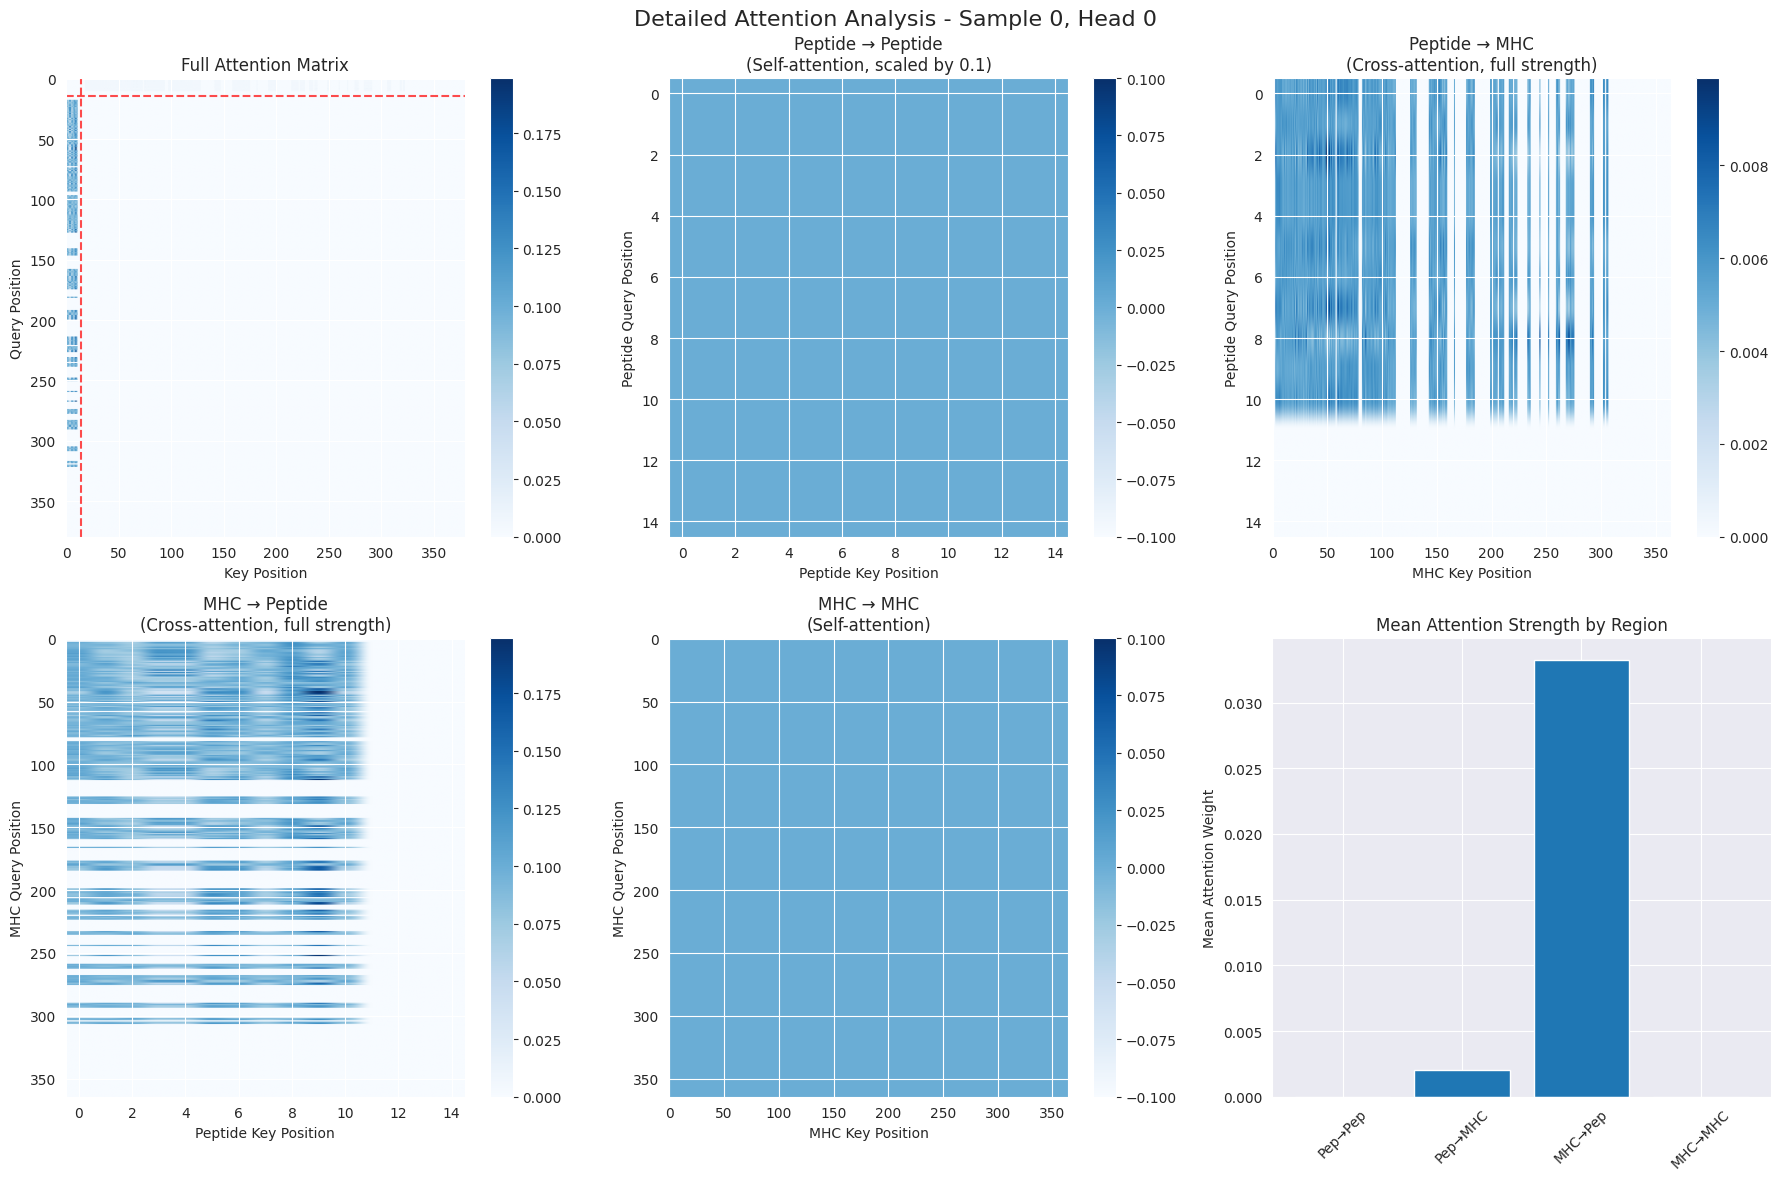


Attention Statistics for Sample 0, Head 0:
Peptide → Peptide: mean=0.0000, max=0.0000
Peptide → MHC: mean=0.0020, max=0.0099
MHC → Peptide: mean=0.0332, max=0.1988
MHC → MHC: mean=0.0000, max=0.0000


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [5]:
def analyze_attention_patterns(attn_weights, pep_len, mhc_len, sample_idx=0, head_idx=0):
    """Analyze and visualize attention patterns in detail"""

    attn_matrix = attn_weights[sample_idx, head_idx, :, :]
    total_len = pep_len + mhc_len

    # Extract different attention regions
    pep_to_pep = attn_matrix[:pep_len, :pep_len]  # Upper-left
    pep_to_mhc = attn_matrix[:pep_len, pep_len:]  # Upper-right
    mhc_to_pep = attn_matrix[pep_len:, :pep_len]  # Lower-left
    mhc_to_mhc = attn_matrix[pep_len:, pep_len:]  # Lower-right

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Detailed Attention Analysis - Sample {sample_idx}, Head {head_idx}', fontsize=16)

    # Full attention matrix
    im1 = axes[0, 0].imshow(attn_matrix, cmap='Blues', aspect='auto')
    axes[0, 0].set_title('Full Attention Matrix')
    axes[0, 0].set_xlabel('Key Position')
    axes[0, 0].set_ylabel('Query Position')
    axes[0, 0].axhline(y=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axvline(x=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    plt.colorbar(im1, ax=axes[0, 0])

    # Peptide to Peptide (should be dim due to 0.1 scaling)
    im2 = axes[0, 1].imshow(pep_to_pep, cmap='Blues', aspect='auto')
    axes[0, 1].set_title('Peptide → Peptide\n(Self-attention, scaled by 0.1)')
    axes[0, 1].set_xlabel('Peptide Key Position')
    axes[0, 1].set_ylabel('Peptide Query Position')
    plt.colorbar(im2, ax=axes[0, 1])

    # Peptide to MHC (should be strong)
    im3 = axes[0, 2].imshow(pep_to_mhc, cmap='Blues', aspect='auto')
    axes[0, 2].set_title('Peptide → MHC\n(Cross-attention, full strength)')
    axes[0, 2].set_xlabel('MHC Key Position')
    axes[0, 2].set_ylabel('Peptide Query Position')
    plt.colorbar(im3, ax=axes[0, 2])

    # MHC to Peptide (should be strong)
    im4 = axes[1, 0].imshow(mhc_to_pep, cmap='Blues', aspect='auto')
    axes[1, 0].set_title('MHC → Peptide\n(Cross-attention, full strength)')
    axes[1, 0].set_xlabel('Peptide Key Position')
    axes[1, 0].set_ylabel('MHC Query Position')
    plt.colorbar(im4, ax=axes[1, 0])

    # MHC to MHC (depends on self_attn_mhc parameter)
    im5 = axes[1, 1].imshow(mhc_to_mhc, cmap='Blues', aspect='auto')
    axes[1, 1].set_title('MHC → MHC\n(Self-attention)')
    axes[1, 1].set_xlabel('MHC Key Position')
    axes[1, 1].set_ylabel('MHC Query Position')
    plt.colorbar(im5, ax=axes[1, 1])

    # Statistics plot
    axes[1, 2].bar(['Pep→Pep', 'Pep→MHC', 'MHC→Pep', 'MHC→MHC'],
                   [pep_to_pep.mean(), pep_to_mhc.mean(),
                    mhc_to_pep.mean(), mhc_to_mhc.mean()])
    axes[1, 2].set_title('Mean Attention Strength by Region')
    axes[1, 2].set_ylabel('Mean Attention Weight')
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nAttention Statistics for Sample {sample_idx}, Head {head_idx}:")
    print(f"Peptide → Peptide: mean={pep_to_pep.mean():.4f}, max={pep_to_pep.max():.4f}")
    print(f"Peptide → MHC: mean={pep_to_mhc.mean():.4f}, max={pep_to_mhc.max():.4f}")
    print(f"MHC → Peptide: mean={mhc_to_pep.mean():.4f}, max={mhc_to_pep.max():.4f}")
    print(f"MHC → MHC: mean={mhc_to_mhc.mean():.4f}, max={mhc_to_mhc.max():.4f}")

    return attn_matrix


def check_mask_effects(p_mask, m_mask, sample_idx=0):
    """Check how masking affects the attention patterns"""

    pep_mask_sample = p_mask[sample_idx].numpy()
    mhc_mask_sample = m_mask[sample_idx].numpy()

    print(f"\nMask Analysis for Sample {sample_idx}:")
    print(f"Peptide mask: {pep_mask_sample}")
    print(f"MHC mask: {mhc_mask_sample}")
    print(f"Valid peptide positions: {np.sum(pep_mask_sample > 0)}")
    print(f"Valid MHC positions: {np.sum(mhc_mask_sample > 0)}")
    print(f"Masked peptide positions: {np.sum(pep_mask_sample == MASK_TOKEN)}")
    print(f"Padded peptide positions: {np.sum(pep_mask_sample == PAD_TOKEN)}")
    print(f"Padded MHC positions: {np.sum(mhc_mask_sample == PAD_TOKEN)}")


# Analyze attention patterns and mask effects
analyze_attention_patterns(attn_weights, pep_len, mhc_len, sample_idx=0, head_idx=0)
check_mask_effects(pep_mask, mhc_mask, sample_idx=0)

# Demonstrate dynamic masking effects
print("\nDemonstrating dynamic masking effects...")
masked_batch = train_generator[0]  # Get a training batch with masking applied
print(f"Sample masks in training batch:")
print(f"Peptide mask values: {np.unique(masked_batch['pep_mask'][0].numpy())}")
print(f"MHC mask values: {np.unique(masked_batch['mhc_mask'][0].numpy())}")
print(
    f"Positions with MASK_TOKEN ({MASK_TOKEN}): Peptide={np.sum(masked_batch['pep_mask'][0].numpy() == MASK_TOKEN)}, MHC={np.sum(masked_batch['mhc_mask'][0].numpy() == MASK_TOKEN)}")
